In [1]:
import torch
import torchvision
from torchvision import transforms,datasets,models
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.seed=41
import matplotlib.pyplot as plt

In [2]:
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)

'GeForce GTX 1650 with Max-Q Design'

In [3]:
torch.cuda.empty_cache()

In [4]:
train_set = datasets.MNIST('./data', train=True, download=False)
test_set = datasets.MNIST('./data', train=False, download=False)
train_img = train_set.data.numpy()
test_img = test_set.data.numpy()
# rgb_batch = np.repeat(grayscale_batch[..., train_img], 3, -1)
train_img = train_img.reshape(-1, 28, 28,1)
train_img.shape

(60000, 28, 28, 1)

In [5]:
batch_size = 400
train_images = torch.Tensor(train_img).view(train_img.shape[0],1,28,28).to(device)
test_images = torch.Tensor(test_img).view(test_img.shape[0],1,28,28).to(device)
train_images.shape

torch.Size([60000, 1, 28, 28])

In [6]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=stride, padding=1).to(device)
def convT3x3(in_channels, out_channels, stride=1,padding=1):
    return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3,stride=stride, padding=padding).to(device)

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.subblock_1=nn.Sequential(
            conv3x3(in_channels, out_channels, stride).to(device),
            nn.BatchNorm2d(out_channels).to(device),
            nn.ReLU()
        )
        self.subblock_2=nn.Sequential(
            conv3x3(out_channels, out_channels).to(device),
            nn.BatchNorm2d(out_channels).to(device),
            nn.ReLU(),
        )
        self.downsample = downsample
    def forward(self, x):
        residual = x
        x = self.subblock_1(x).to(device)
        x = self.subblock_2(x).to(device)
        if self.downsample:
            residual = self.downsample(residual)
        x += residual
        x = F.relu(x)        
        return x
block=ResidualBlock
class DecoderResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1,padding=1,upsample=None):
        super(DecoderResidualBlock, self).__init__()
        self.subblock_1=nn.Sequential(
            convT3x3(in_channels, out_channels, stride,padding).to(device),
            nn.BatchNorm2d(out_channels).to(device),
            nn.ReLU()
        )
        self.subblock_2=nn.Sequential(
            convT3x3(out_channels, out_channels).to(device),
            nn.BatchNorm2d(out_channels).to(device),
            nn.ReLU(),
        )
        self.upsample = upsample
    def forward(self, x):
        residual = x
        x = self.subblock_1(x).to(device)
#         print(x.shape)
        x = self.subblock_2(x).to(device)
#         print(x.shape)
        if self.upsample:
            residual = self.upsample(residual)
#         print("LOL")
#         print(x.shape)
#         print(residual.shape)
        x += residual
        x = F.relu(x)        
        return x
decoder_block=DecoderResidualBlock
decoder_block

__main__.DecoderResidualBlock

In [8]:
# ResNet
class ResNet(nn.Module):
    def __init__(self,num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels=16
        self.in_channels_decoder=32
        self.layer=nn.Sequential(
            conv3x3(1, 16).to(device),
            nn.BatchNorm2d(16).to(device),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(block,16,2).to(device)
        self.layer2 = self.make_layer(block, 32,2,2).to(device)
        self.layer3 = self.make_layer(block, 64,2,2).to(device)
        self.max_pool = nn.MaxPool2d(7,1).to(device)
        self.fc = nn.Flatten()
        self.trans_layer1 = self.make_trans_layer(decoder_block,32,2).to(device)
        self.trans_layer2 = self.make_trans_layer(decoder_block, 16,2,2).to(device)
        self.trans_layer3 = self.make_trans_layer(decoder_block,3,2,2).to(device)
        self.trans_layer4 = nn.ConvTranspose2d(3,1,4,2,2).to(device)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride).to(device),
                nn.BatchNorm2d(out_channels).to(device)
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def make_trans_layer(self, decoder_block, out_channels, blocks, stride=1,padding=0):
        upsample = None
        if (stride != 1) or (self.in_channels_decoder != out_channels):
            upsample = nn.Sequential(
                convT3x3(self.in_channels_decoder, out_channels, stride=stride,padding=padding).to(device),
                nn.BatchNorm2d(out_channels).to(device)
            )
        layers_dec = []
        layers_dec.append(decoder_block(self.in_channels_decoder, out_channels, stride,padding, upsample))
        self.in_channels_decoder = out_channels
        for i in range(1, blocks):
            layers_dec.append(decoder_block(out_channels, out_channels))
#         print(*layers_dec)
        return nn.Sequential(*layers_dec)

    def forward(self, x):
        x=self.layer(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.max_pool(x)
        latent = self.fc(x)
        mean,std=torch.chunk(latent,2,dim=1)
        sample = mean + torch.randn_like(std)*std
        x=sample.view(sample.shape[0],32,1,1)
#         print(x.shape)
        x = self.trans_layer1(x)
        x = self.trans_layer2(x)
        x = self.trans_layer3(x)
        x = self.trans_layer4(x)
        return x,mean,std
AutoEncoder=ResNet()

In [9]:
print(AutoEncoder)

ResNet(
  (layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (subblock_1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (subblock_2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): ResidualBlock(
      (subblock_1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (subbl

In [10]:
import torch.optim as optim
optimiser = torch.optim.Adam(AutoEncoder.parameters(), lr=0.005)
loss_list = []

In [11]:
def variational_loss(output,X_in,mean,std):
    loss_function = nn.MSELoss()
    loss_by_function=loss_function(output,X_in)
    kl_loss= -0.00125*torch.sum(1+torch.log(torch.pow(std,2)+1e-10)-torch.pow(std,2)-torch.pow(mean,2))
    total_loss=loss_by_function+kl_loss
    return total_loss

In [12]:
def train(X):
    for epoch in range(0,10):
        cost = 0
#         batch = torch.from_numpy(np.arange(0,X.shape[0],dtype="int64"))
#If you would like to check with arange instead of randperm, then uncomment above and comment below lines respectively
        batch=torch.randperm(X.shape[0]).to(device)
        for i in range(0, X.shape[0],batch_size):
            output,mean,std = AutoEncoder(X[batch[i:i+batch_size]].to(device))
            optimiser.zero_grad()
#             rev_fc=nn.ConvTranspose2d(3,1,2,1,0)
#             X=rev_fc(X)
            loss=variational_loss(output,X[batch[i:i+batch_size]],mean,std)
            cost = cost+loss.item() 
            loss.backward()
            optimiser.step()
        loss_avg = cost / X.shape[0]
        loss_list.append(loss_avg)
        print("For iteration: ", epoch+1, " the loss is :", loss_avg)
#         a=mean.detach().numpy()
#         plt.scatter(a[:,0],a[:,1])
#         break
    return loss_list

For iteration:  1  the loss is : 12.629366955566406
For iteration:  2  the loss is : 5.1447514567057295
For iteration:  3  the loss is : 3.5474866923014323
For iteration:  4  the loss is : 2.9456466532389323
For iteration:  5  the loss is : 2.6992278778076173
For iteration:  6  the loss is : 2.4601367584228515
For iteration:  7  the loss is : 2.2887098520914715
For iteration:  8  the loss is : 2.108042596435547
For iteration:  9  the loss is : 1.9993664286295574
For iteration:  10  the loss is : 1.9160441721598307


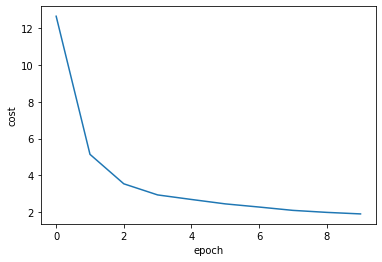

In [13]:
import matplotlib.pyplot as plt
train_loss= train(train_images)
plt.plot(loss_list)
plt.ylabel('cost')
plt.xlabel('epoch')
plt.show()

In [14]:
def test(X):
    with torch.no_grad():
        cost=0
        batch=torch.randperm(X.shape[0])
        for i in range(0, X.shape[0],batch_size):
            output,mean,std=AutoEncoder(X[batch[i:i+batch_size]])
            loss=variational_loss(output,X[batch[i:i+batch_size]],mean,std)
            cost=cost+loss.item()
        print(cost/X.shape[0])
test(test_images)

1.842383203125


In [15]:
torch.cuda.empty_cache()

MNIST Image


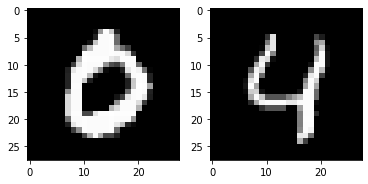

Image through Variational AutoEncoder


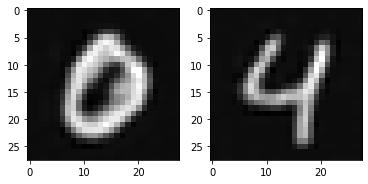

In [16]:
#Normal Image
print("MNIST Image")
fig, axes = plt.subplots(1,2)
axes[0].imshow(test_img[3],cmap="gray")
axes[1].imshow(test_img[4],cmap="gray")

plt.show()

print("Image through Variational AutoEncoder")
# print(test_images[1:45].shape)
output=AutoEncoder(test_images[:5])
output_img=((output[0].to(torch.device('cpu'))).detach().numpy()).reshape(5,28,28)

fig, axes = plt.subplots(1,2)
axes[0].imshow(output_img[3],cmap="gray")
axes[1].imshow(output_img[4],cmap="gray")
plt.show()

In [17]:
# https://medium.com/@galexik81/5-lifesaving-pytorch-functions-519d134df9b1
#Visit the above blog to know more about torch.chunk